# Multi-class Classification and Neural Networks

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io  # Used to load the OCTAVE *.mat files

import scipy.misc                    # Used to show matrix as an image
from scipy.optimize import minimize  # minimizes parameteres with cost and grad functions

import matplotlib.cm as cm       # Used to display images in a specific colormap
import random
from scipy.special import expit  # Vectorized sigmoid function

## Visualize the data

In [2]:
def ndarray_description(x):
    return "shape: {}, min: {}, max: {}".format(x.shape, x.min(), x.max())

In [5]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat(datafile)
X, y = mat['X'], mat['y']

# insert column of ones
X = np.insert(X, 0, 1, axis=1)

In [6]:
print("X", ndarray_description(X))  # 5000 images with 400 pixels (20x20)
print("y", ndarray_description(y))  # Labeled classification 1-10, 10 represents 0

X shape: (5000, 401), min: -0.13196323019852488, max: 1.127688299158888
y shape: (5000, 1), min: 1, max: 10


(-0.5, 399.5, 19.5, -0.5)

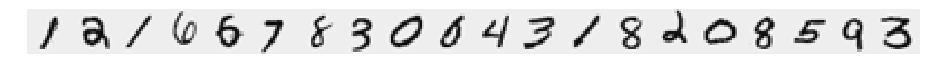

In [28]:
sample = np.random.choice(X.shape[0], 20)  # 20 row indices from X

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(X[sample, 1:].reshape(-1,20).T, cmap='gray_r')  # 0 index is 1 constant
ax.axis('off')

## Multi-class Classification

#### Logistic regression hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [29]:
def hypothesis(theta, X):
    """Vectorized computation of the hypothesis for each example X with a set of theta values.
    
    X dot-product theta takes 401 x(i) values in a row of X (a vector) and
    multiples them with the 401 theta vector values. A.t * B = B.t * A if both are 
    vectors, so this vectorizes the g(theta.t * x) logistic hypothesis for all 5000
    examples in X.
    
    :param numpy.ndarray theta: 401x1 vector of theta values
    :param numpy.ndarray X: 5000x401 matrix of examples
    
    :returns: 5000x1 array
    :rtype: numpy.ndarray
    """
    return expit(np.dot(X, theta))

## Cost function

#### Regularized Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [78]:
def cost(theta, X, y, learning_rate=0.): 
    """Calculate the total cost for every example with a set of parameter values.
    
    Set learning_rate to non-zero to include regularization.

    :param numpy.ndarray theta: An n- dimensional vector of parameter values (401x1)
    :param numpy.ndarray X: An array of examples with n columns and m rows (5000x401)
    :param numpy.ndarray y: The labeled prediction vector, m rows and 1 column (5000x1)
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :rtype: np.array[numpy.float64]
    """
    m = X.shape[0]            # 5000
    h = hypothesis(theta, X)  # 5000x1 vector
    
    # use dot product to sum all terms in y * log(h) vectors
    term1 = np.log(h).T.dot(-1*y)   # scalar
    term2 = np.log(1-h).T.dot(1-y)  # scalar
    reg = (learning_rate/(2*m)) * np.sum(np.square(theta[1:]))  # scalar, exclude theta[0]
    
    J = (1/m)*(term1-term2) + reg  # still 1x1 vectors
    
    if np.isnan(J[0]):
        return np.inf
    
    return J[0]

In [79]:
# initial_theta = np.random.uniform(X.min(), X.max(), (X.shape[1], 1))  # 401x1
initial_theta = np.zeros((X.shape[1],1))
print("initial_theta", ndarray_description(initial_theta))

initial_theta shape: (401, 1), min: 0.0, max: 0.0


In [80]:
h = hypothesis(initial_theta, X)  # 5000x1
print("h", ndarray_description(h))

h shape: (5000, 1), min: 0.5, max: 0.5


In [92]:
J = cost(initial_theta, X, y)
print("J", ndarray_description(J))

J shape: (1,), min: 160.39425758157174, max: 160.39425758157174


#### Regularized Gradient

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### ...vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [86]:
def cost_gradient(theta, X, y, learning_rate=0.):
    """Calculate the gradient for every theta value.
    
    Set learning_rate to non-zero to include regularization.

    :param numpy.ndarray theta: An n- dimensional vector of parameter values (401x1)
    :param numpy.ndarray X: An array of examples with n columns and m rows (5000x401)
    :param numpy.ndarray y: The labeled prediction vector, m rows and 1 column (5000x1)
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :returns: 401x5000 array
    :rtype: numpy.ndarray
    """
    m = X.shape[0]                          # 5000
    h = hypothesis(theta, X).reshape(-1,1)  # 5000x1 vector
    
    beta = h - y
    reg = ((1.0/m) * initial_theta[1:]).reshape(-1,1)  # 400x1
    reg = np.insert(reg, 0, 0).reshape(-1,1)           # insert a 0 for theta[0], 401x1
    
    grad = (1/m) * X.T.dot(beta)                       # 401x1
    
    return (grad + reg).flatten()  # 401x1

In [87]:
g = cost_gradient(initial_theta, X, y)
print("g", ndarray_description(g))

g shape: (401,), min: -5.0, max: 0.004095720569551439


## One vs All Classification

In [173]:
def one_vs_all(features, classes, K, learning_rate):
    """Compute optimal parameters for the features (X) to each class 1...K (y).
        
    :param numpy.ndarray features: An array of examples with n columns and m rows (5000x401)
    :param numpy.ndarray classes: The labeled prediction vector, m rows and 1 column (5000x1)
    :param int K: The number of classes in the classes array
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :returns: an array of theta values for each class, 10x401
    :rtype: numpy.ndarray
    """
    initial_theta = np.zeros((X.shape[1], 1))  # 401x1
    all_thetas = np.zeros((K, X.shape[1]))     # 10x401
    
    # labels 1 to 10
    for c in np.arange(1, K+1):
        res = minimize(cost, initial_theta, args=(X, (classes == c)*1, learning_rate),
                       method=None, jac=cost_gradient, options={'maxiter': 50})
        all_thetas[c-1] = res.x  # res.x is (401,) ndarray
    
    return all_thetas

In [174]:
optimal_thetas = one_vs_all(X, y, 10, 0.1)
print("optimal_thetas", ndarray_description(optimal_thetas))

optimal_thetas shape: (10, 401), min: -8.597227620895094, max: 2.69050229712157


### Prediction

In [175]:
def predict_one_vs_all(theta, X):
    """Returns a vector of class predictions (1-10) for each row in X.
    
    :param numpy.ndarray theta: An array where each row contains a set of theta values, 10x401
    :param numpy.ndarray X: An array where each row contains the bias + variables, 5000x401
    
    :returns: An array of predictions (1-10) for each example, 5000x1
    :rtype: numpy.ndarray
    """
    # For each example (row) in X, compute the probability it belongs to each class
    # transpose theta to get 5000x401 * 401x10 (X.dot(theta))
    probability = expit(np.dot(X, theta.T))    # 5000x10
    
    # Each row in probability is an array of the probability for each class 0-9
    # find the highest probability in each row, take it's index and add one for 1-10
    # return a vector of predictions 1-10
    return np.argmax(probability, axis=1) + 1  # 5000x1

In [176]:
predictions = predict_one_vs_all(optimal_thetas, X)

# compare each prediction to y, add them all up, and take average of matches
accuracy = np.mean(predictions == y.ravel()) * 100
print("Training set accuracy:", accuracy)

Training set accuracy: 93.26


## Predictions with sklearn

In [165]:
from sklearn.linear_model import LogisticRegression

In [178]:
# C - Inverse of regularization strength
# penalty - norm used in the penalization
# solver - Algorithm to use in the optimization problem
# specified multi_class to its default to avoid a future warning
clf = LogisticRegression(C=10, penalty='l2', solver='liblinear', multi_class='ovr')

# Scikit inserts the intercept (first column of 1s) so exclude it from my X
clf.fit(X[:, 1:], y.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [180]:
model_predictions = clf.predict(X[:, 1:])
model_accuracy = np.mean(predictions == y.ravel()) * 100
print("Training set accuracy:", model_accuracy)

Training set accuracy: 93.26


## Neural Networks
First load given optimized theta values for each layer

In [182]:
datafile = 'data/ex3weights.mat'
mat = scipy.io.loadmat(datafile)
theta_1, theta_2 = mat["Theta1"], mat["Theta2"]
print("theta_1", ndarray_description(theta_1))
print("theta_2", ndarray_description(theta_2))

theta_1 shape: (25, 401), min: -1.463369318005054, max: 1.0089920104197974
theta_2 shape: (10, 26), min: -4.030847527504247, max: 3.2115848427114373


In [212]:
def predict_neural_network(theta_1, theta_2, features):
    z2 = theta_1.dot(features.T)      # 25x401 dot 401x5000
    a2 = expit(z2)                    # 25x5000
    a2 = np.insert(a2, 0, 1, axis=0)  # 26x5000, insert row of 1s
    
    z3 = theta_2.dot(a2)  #10x5000
    a3 = expit(z3)
    
    return np.argmax(a3, axis=1) + 1

In [220]:
nn_predictions = predict_neural_network(theta_1, theta_2, X)
nn_predictions.shape

(10,)

In [219]:
# accuracy = np.mean(predictions == y.ravel()) * 100
# print("Training set accuracy:", accuracy)

nn_accuracy = np.mean(nn_predictions == y.ravel()) * 100
print("Training set accuracy:", nn_accuracy)

Training set accuracy: 0.0


/Users/joeselvik/.virtualenvs/machine-learning-coursera/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
